## This notebook aims to create a set of output layers in the hunt for springs.  

##FIXME

- it uses WOfS and tasselled cap wetness to look at potential location and seasonality of springs
 - it outputs a layer of water bodies identified using WOFS where water is present >90% of obs 
 - it outputs a layer intersecting with major rivers
 - it then calculates tasselled cap wetness in the same area, and calculates either overthreshold wetness or percentiles, I haven't decided yet. 
 

### load some modules

In [23]:
%matplotlib inline

#load common modules
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr


# load more specific modules - check we need all of these
import rasterio.features
from shapely.geometry import Polygon, shape
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import geopandas as gp

#plotting libraries
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import colors

#modules for datacube -local/specific modules
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf
from datacube_stats.statistics import Percentile
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser ## this is the group_by for wofs! 

# Import external functions from dea-notebooks --note Scripts directory has moved recently
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/')) #-remove this when it's no longer necessary
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts/'))
import DEAPlotting, DEADataHandling, TasseledCapTools

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-wofs_tci_workflows')

#use autoreload
%load_ext autoreload
%autoreload 2

### set up a query to request an area and epoch from DEA

In [24]:
# #Test area of LBG
# query = {
#         'lat': (-35.25, -35.35),
#         'lon': (149.05, 149.17),
#         'time':('2015-01-01', '2017-01-31')
#         }

In [3]:
#realise that you can't test this workflow where there is possibly no wofs!!!

In [4]:
# query = {'lat': (-19.811706, -19.814554),
#          'lon': (145.289547, 145.272579),
#          'time':('2016-10-01', '2017-05-01')
#          }

In [5]:
query = {'lat': (-19.94, -20.109),
         'lon': (145.383,145.684),
         'time':('2016-10-01', '2017-05-01')
         }

### load wofs

In [6]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

wofls = dc.load(product = 'wofs_albers',group_by='solar_day', fuse_func=wofs_fuser, **query)

### work out wofs percentage as the percentage of observations where wofs=wet, over the stack that wofs had valid observations (obs were wet or dry)

In [21]:
#count wet observations
wetwofls = masking.make_mask(wofls, wet=True)
#count where water = True
wofs_count = wetwofls.sum(dim='time', keep_attrs=True) 
#wofs_count.water.plot()
#plt.show()

#count dry observations
drywofls = masking.make_mask(wofls, dry=True) 
dry_wofs_count = drywofls.sum(dim='time', keep_attrs=True)
#dry_wofs_count.water.plot()
#plt.show()

#wofs percentage = wofs where wet or dry (valid data)
wofs_percentage = ((wofs_count/(dry_wofs_count+wofs_count))*100)
#wofs_percentage.where(wofs_percentage!=0).water.plot(figsize=(10,10))
#plt.show()

In [ ]:
def discrete_colour_bar_plot(ds:
""" this function """
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import colors

In [14]:
###

bounds = list(range(0, 110,10))

sns_cmap = colors.ListedColormap(sns.cubehelix_palette(n_colors=len(bounds),start=.5, rot=-.75).as_hex())
#sns_cmap = sns.cubehelix_palette(n_colors=len(boundaries),as_cmap=True)
#hex_colors = [hex_colors[i] for i in range(0, len(hex_colors))]
norm =mpl.colors.BoundaryNorm(bounds, sns_cmap.N)

In [49]:
plt.figure(figsize=(13,13))
img = plt.imshow(wofs_percentage.water,
                 cmap=sns_cmap, norm=norm)
cbar = plt.colorbar((img, cmap=sns_cmap, norm=norm, boundaries=bounds), ticks=[i + 5 for i in bounds[:-1]])
bar.ax.set_yticklabels(['Class 1', 'Class 2', 'Class 3'])
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (<ipython-input-49-b03ffb0e7c70>, line 4)

In [61]:
wofs_percentage.water.attrs = wofs_percentage.attrs

In [128]:
def plot_WOfS(ds, figsize=(10,10), title='WOfS %', projection='projected'):
    """Use the DEA WOfS color ramp to plot WOfS percentage data. 
    
    Last modified: August 2018
    Authors: Bex Dunn, Mike Barnes, Claire Krause, Cate Kooymans and Robbi Bishop-Taylor
    This function uses code from the 'three band image' function 
    of DEAPlotting, authored by Mike Barnes, Claire Krause, Cate Kooymans and Robbi Bishop-Taylor
    
    :param ds:
    An xarray dataset containing the bands to be plotted. For correct axis scales, the xarray
    will ideally have spatial data (e.g. an `.extent` method)

     :param figsize:
    Optional tuple or list giving the dimensions of the output plot (defaults to `(10, 10)`)

    :param title:
    Optional string for the plot title. If left as the default 'Time', the title will be taken from
    the timestep of the plotted image if available

    :param projection:
    Determines if the image is in degrees or northings (options are 'projected' or 'geographic')

    :return fig:
    A matplotlib figure object for customised plotting
    
    :return ax:
    A matplotlib axis object for customised plotting    
    """
    
    from matplotlib.colors import ListedColormap
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    #hex definitions for the color map    
    wofs_cmap = mpl.colors.ListedColormap(['#000000', '#e38400', '#e3df00', '#62e300',
                                           '#00e384', '#00e3c8', '#00c5e3', '#0097e3', 
                                           '#005fe3', '#000fe3', '#5700e3'])
    #color steps
    wofs_bounds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    wofs_norm = mpl.colors.BoundaryNorm(wofs_bounds, wofs_cmap.N)
      
    #Create WOfS image with specified colour ramp details
    # Plot figure, setting x and y axes from extent of xarray dataset
    fig, ax = plt.subplots(figsize=figsize)
    try:

        # Plot with correct coords by setting extent if dataset has spatial data (e.g. an `.extent` method).
        # This also allows the resulting image to be overlaid with other spatial data (e.g. a polygon or point)
        left, bottom, right, top = ds.extent.boundingbox
        i = ax.imshow(ds,cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100, extent=[left, right, bottom, top])

    except:

        # Plot without coords if dataset has no spatial data (e.g. an `.extent` method)
        print("xarray dataset has no spatial data; defaulting to plotting without coordinates. "
              "This can often be resolved by adding `keep_attrs = True` during an aggregation step")
        i =ax.imshow(ds,cmap = wofs_cmap,norm=wofs_norm,vmin = 0, vmax = 100)    
    
    # Manually defined title
    ax.set_title(title, fontweight='bold', fontsize=14)

    # Set x and y axis titles depending on projection
    if projection == 'geographic':

        ax.set_xlabel('Longitude', fontweight='bold')
        ax.set_ylabel('Latitude', fontweight='bold')
        
    else:

        ax.set_xlabel('Eastings', fontweight='bold')
        ax.set_ylabel('Northings', fontweight='bold')
    
    #set colorbar into axes on the right hand side of image ax at width of size %, pad of 0.15 inch from image
    divider=make_axes_locatable(ax)  
    cax=divider.append_axes("right", size = "4%", pad =0.15)
    plt.colorbar(i, ticks=wofs_bounds, cax=cax).set_label(label='WOfS (%)',size=12) #Add definable colour bar
    #fig.delaxes(fig.axes[1]) #Remove pre-defined colour bar
    return fig,ax


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb26b43a8d0>)

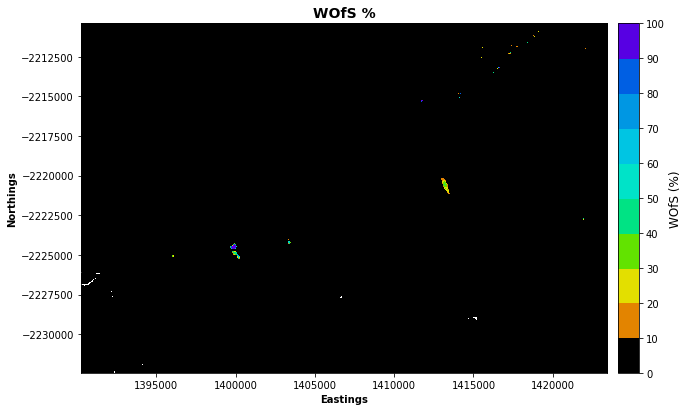

In [129]:
plot_WOfS(wofs_percentage.water)

In [32]:
wofs_percentage.attrs = ds.attrs

In [34]:
wofs_percentage.extent

Geometry(POLYGON ((1390250 -2210400,1390250 -2232425,1423425 -2232425,1423425 -2210400,1390250 -2210400)), EPSG:3577)

## Sort waterbodies into Lacustrine (>8ha, 80000m^2), Palustrine, Riverine (ignoring estuarine, marine, subterranean)
e.g. (qld des wetland link)[https://wetlandinfo.ehp.qld.gov.au/wetlands/what-are-wetlands/definitions-classification/system-definitions.html ]

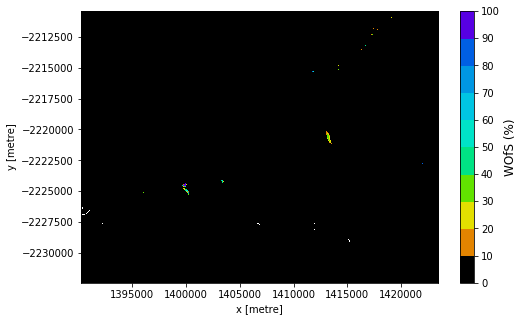

In [39]:
plot_wofs(wofs_percentage.water)

In [16]:
#load landsat data for the same time period
ds = DEADataHandling.load_clearlandsat(dc, query, masked_prop=0)

Loading ls5 PQ
    Skipping ls5
Loading ls7 PQ
    Loading 10 filtered ls7 timesteps
Loading ls8 PQ
    Loading 13 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


In [19]:
tci = TasseledCapTools.thresholded_tasseled_cap(ds, wetness_threshold=-350, drop_tc_bands=False)

In [22]:
tci

<xarray.Dataset>
Dimensions:                 (time: 23, x: 1327, y: 881)
Coordinates:
  * y                       (y) float64 -2.21e+06 -2.21e+06 -2.21e+06 ...
  * x                       (x) float64 1.39e+06 1.39e+06 1.39e+06 1.39e+06 ...
  * time                    (time) datetime64[ns] 2016-10-07T00:17:29 ...
Data variables:
    greenness               (time, y, x) float64 531.1 556.8 522.5 496.9 ...
    greenness_thresholded   (time, y, x) float64 nan nan nan nan nan nan nan ...
    brightness              (time, y, x) float64 2.934e+03 2.883e+03 ...
    brightness_thresholded  (time, y, x) float64 nan nan nan nan nan nan nan ...
    wetness                 (time, y, x) float64 -2.046e+03 -1.971e+03 ...
    wetness_thresholded     (time, y, x) float64 nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577

In [11]:
MajorRivers = gp.GeoDataFrame.from_file('/g/data/r78/cek156/ShapeFiles/SurfaceHydrologyLinesRegionalFilteredMAJOR.shp') 

In [13]:
WOFSOFSbreaktuple = [a for a, b in list(WOFSOFSbig)]

# Grab the geometeries
for poly in WOFSOFSbreaktuple:
    poly['geometry'] = shape(poly)
    
WOFSOFSfiltered2p0 = gp.GeoDataFrame(WOFSOFSbreaktuple).set_geometry('geometry')
Intersections= gp.sjoin(MajorRivers, WOFSOFSfiltered2p0, how="inner", op='intersects')
IntersectIndex = sorted(list(set(Intersections['index_right'])))

WOFSOFS = [WOFSOFSbreaktuple[x] for x in range(len(WOFSOFSbreaktuple)) 
                                  if x not in IntersectIndex]

NameError: name 'WOFSOFSbig' is not defined